In [1]:
import csv
import subprocess
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import shutil

In [53]:
class Experiment:
    def __init__(self, functions_file, optimization_file, opt_folder, fig_folder):
        self.functions_file = functions_file
        self.optimization_file = optimization_file
        self.functions_param=[]
        self.optimization_param=[]
        
        
        self.f_param_list_function_id=[]
        self.f_param_list_name=[]
        self.f_param_list_range_low=[]
        self.f_param_list_range_high=[]
        self.f_param_list_dimensions_vector=[]
            
        self.opt_param_list_id = []
        self.opt_param_list_name = []
        self.opt_param_list_config_file = []
            
        self.readFunctionsFile()
        self.readOptimizationFile()
        self.opt_folder = opt_folder
        self.fig_folder = fig_folder
        self.solution_file = "solutions.csv"
        self.solution_df = None
        
        #detect os windows or linux
        if os.name == 'nt':
            # Windows
            self.exec = "../bin/release/project.exe"
        else:
            # other (linux)
            self.exec = "../bin/release/project.o"
        
    def readFunctionsFile(self):
        with open(self.functions_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.functions_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.functions_param)):
            self.f_param_list_function_id.append(self.functions_param[i][0]) #function_id
            self.f_param_list_name.append(self.functions_param[i][1]) # function name
            self.f_param_list_range_low.append(self.functions_param[i][2]) # range low
            self.f_param_list_range_high.append(self.functions_param[i][3]) # range high
            self.f_param_list_dimensions_vector.append(self.functions_param[i][4:]) # dimension vector, from 4 to the last element
            
    def readOptimizationFile(self):
        with open(self.optimization_file) as csvfile:
            read_csv = csv.reader(csvfile, delimiter=',')
            for row in read_csv:
                self.optimization_param.append(row)
        
        #decode the functions_param
        for i in range(1,len(self.optimization_param)):
            self.opt_param_list_id.append(self.optimization_param[i][0]) #opt algorithm id
            self.opt_param_list_name.append(self.optimization_param[i][1]) #algo name
            self.opt_param_list_config_file.append(self.optimization_param[i][2]) # config file
            
    def delete_all_output_files(self):
        files = glob.glob('a*.csv')
        for f in files:
            os.remove(f)
    def moveFileToOutFolder(self, filename):
        shutil.move(filename, self.opt_folder+filename) # move file to out folder
        
    def merge_all_output_files(self):
        files = glob.glob("a*.csv")

        #print(files)
        solutions=[]
        for f in files:
            with open(f) as csvfile:
                read_csv = csv.reader(csvfile, delimiter=',')
                for i,row in enumerate(read_csv):
                    if i != 0: # first row
                        solutions.append(row)
        #print(solutions)
        
        
        with open(self.solution_file, mode='w') as solution_file:
            writer = csv.writer(solution_file, delimiter=',', lineterminator='\n',quotechar='"', quoting=csv.QUOTE_MINIMAL)
            writer.writerow(['algorithm_id'
                             ,'function_id'
                             ,'n_runs'
                             ,'dimensions'
                             ,'range_low'
                             ,'range_high'
                             ,'mean'
                             ,'std_dev'
                             ,'range'
                             ,'median'
                             ,'time_ms'
                             ,'range_min'
                             ,'range_max'
                            ])
            writer.writerows(solutions)
            
    def plot(self):
        df=pd.read_csv(self.opt_folder +'solutions.csv',index_col=False)
        df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
        self.solution_df = df
        
        #-----------plot running time
        fig, ax = plt.subplots(figsize=(8,6))
        for label, data in df.groupby('algorithm_id'):
            data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
        plt.ylabel('time [ms]')    
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()
        plt.title('Running time')
        plt.savefig(self.fig_folder+"running_time.png",bbox_inches='tight')
        
   
        #---------plot statistics
        for id, data in df.groupby('function_id'):
            fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4),gridspec_kw={'width_ratios': [2, 1]})
            ax1.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
            ax1.plot(data['algorithm_id'],data['median'],label='median')
            ax1.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
            locs = [int(i) for i in self.opt_param_list_id]
            names = self.opt_param_list_name
            ax1.set_xticks(locs, minor=False)
            ax1.set_xticklabels(names, rotation=45, horizontalalignment='right')
            #ax1.xticks(locs,, rotation=45, horizontalalignment='right')
            fig.suptitle("f%d : %s"%(id, self.f_param_list_name[id-1]), fontsize=15)
            #ax1.set_title("f%d : %s"%(id, test.f_param_list_name[id-1]))
            #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax1.legend()
            ax1.set_xlabel('Algorithm')
            ax1.set_ylabel('Cost')
            ax1.grid()

            ax2.plot(data['algorithm_id'],data['time_ms'])
            ax2.set_ylabel('CPU Total Running time [ms]')
            ax2.set_xlabel('Algorithm')
            ax2.set_xticks(locs, minor=False)
            ax2.set_xticklabels(names, rotation=45, horizontalalignment='right')
            ax2.grid()
            plt.savefig(self.fig_folder + "f"+str(id)+".png",bbox_inches='tight')

        
    # run all the algorithm, 18 functions in the same time, using many CPU
    # may cause some problem with CPU clock() time... which register the cpu time of whole program
    # it seems that python is a program which call many subprocess using Popen. As a result, all the subprocess are
    # accessing to the same clock?
    def run(self, n_runs):
        
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                    process = subprocess.Popen([
                                    self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]
                                   ])
                    process_list.append(process)

            # wait every process to finish
            for p in process_list:
                p.wait()
            print("----finished----alg: %d"%k)
        
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
    # run all the algorithm in sequence one function after another only only 1 CPU
    def runOneByOne(self, n_runs):    
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    #subprocess.Popen() can be multi process, subprocess.run() need to wait one process to finish
                    process = subprocess.run([
                                    self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]
                                   ])
                    process_list.append(process)

            print("----finished----alg: %d"%k)
        
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
    def runAllLinux(self, n_runs):    
        #delete all temp files
        self.delete_all_output_files()
        
        for k in range(len(self.opt_param_list_id)): # run each optimization algorithm
            process_list = []
            for i in range(len(self.f_param_list_function_id)): # run each function  
                for dimension in self.f_param_list_dimensions_vector[i]: # run different dimensions of each function
                    
                    command_str =  [self.exec
                                    ,self.opt_param_list_id[k] # optimization algorithm id
                                    ,self.opt_param_list_config_file[k]  # optimization configuration file
                                    ,str(n_runs) # number of runs            
                                    ,self.f_param_list_function_id[i] #function_id 
                                    ,str(dimension)
                                    ,self.f_param_list_range_low[i]
                                    ,self.f_param_list_range_high[i]]
                    command_str = ' '.join(command_str)
                    os.system(command_str +' &') # execute in background

            print("----running---alg: %d"%k)
            print("the files should be collected manually using collectFiles()")
        

        
    def collectFiles(self):
        self.merge_all_output_files()
        self.moveFileToOutFolder(self.solution_file)
        #delete all temp files
        self.delete_all_output_files()
        
        

In [54]:
test = Experiment("../config/function_list.csv", # function config file
                  "../config/optimization_alg_list.csv", #optimization algorithm config file
                  "../out/optimization/", # output folder for the result
                  "../out/figures/" # output folder for the figures
                 ) 

In [55]:
test.run(10) # n runs in parallel (the cpu time might not be trustful)
#test.runOneByOne(1)

----finished----alg: 0
----finished----alg: 1
----finished----alg: 2
----finished----alg: 3
----finished----alg: 4
----finished----alg: 5
----finished----alg: 6
----finished----alg: 7
----finished----alg: 8
----finished----alg: 9
----finished----alg: 10
----finished----alg: 11
----finished----alg: 12


In [102]:
#test.runAllLinux(50)

In [103]:
#test.collectFiles()

In [56]:
# Tuning
#Calibration 
df=pd.read_csv('../out/optimization/solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)
#tuning function 
df_f=df[df['function_id']==1]


pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.3f}'.format
#df
df_f

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,10,30,-512,512.000,247.124,153.399,592.658,237.206,22086,0.081,592.739
72,1,1,10,30,-512,512.000,382.518,145.361,462.697,459.012,16226,114.754,577.451
90,2,1,10,30,-512,512.000,0.001,0.001,0.002,0.001,19004,0.000,0.002
108,3,1,10,30,-512,512.000,3609.470,222.611,861.189,3609.040,21072,3161.370,4022.560
126,4,1,10,30,-512,512.000,1162.170,297.878,1125.170,1095.690,16208,688.525,1813.700
144,5,1,10,30,-512,512.000,-0.002,0.000,0.001,-0.002,15655,-0.002,-0.001
162,6,1,10,30,-512,512.000,1933.600,204.884,676.156,1850.790,22122,1610.230,2286.390
180,7,1,10,30,-512,512.000,5246.210,158.108,476.000,5226.350,17880,4992.790,5468.790
198,8,1,10,30,-512,512.000,2039.600,647.134,2076.090,2136.160,15927,1151.270,3227.360
216,9,1,10,30,-512,512.000,1983.420,333.976,1122.800,2012.400,19435,1388.090,2510.900


pd.options.display.float_format = '{:.3f}'.format
df

plt.plot(df_f['algorithm_id'],df_f['mean'])
plt.grid()
plt.xticks(df_f['algorithm_id'])

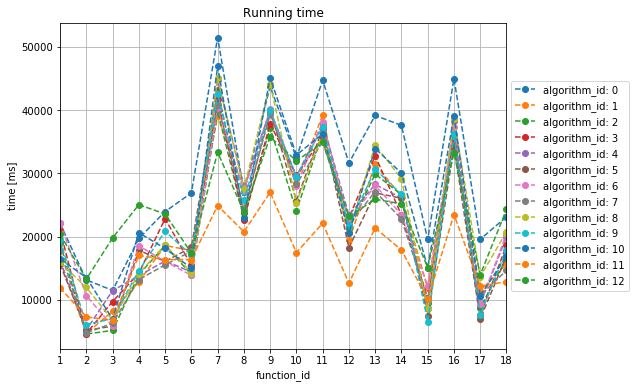

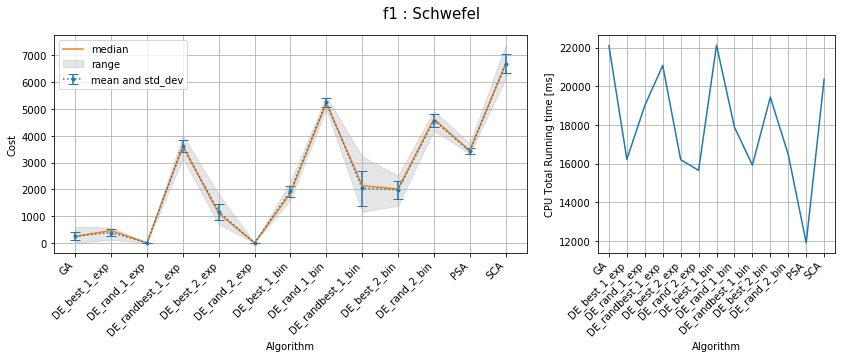

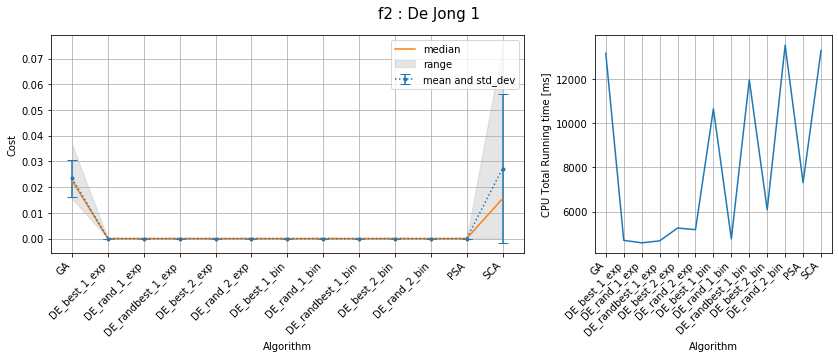

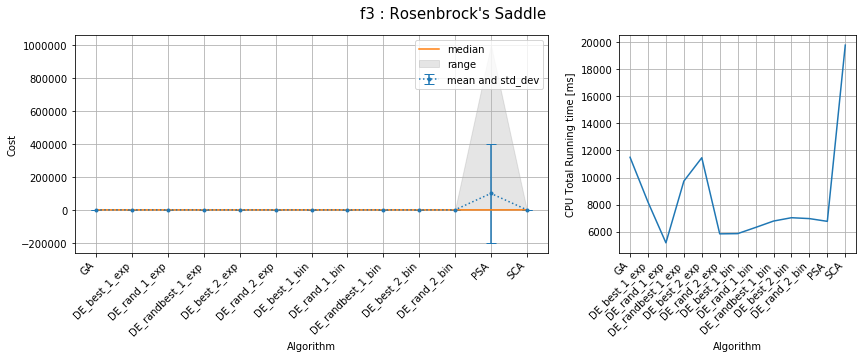

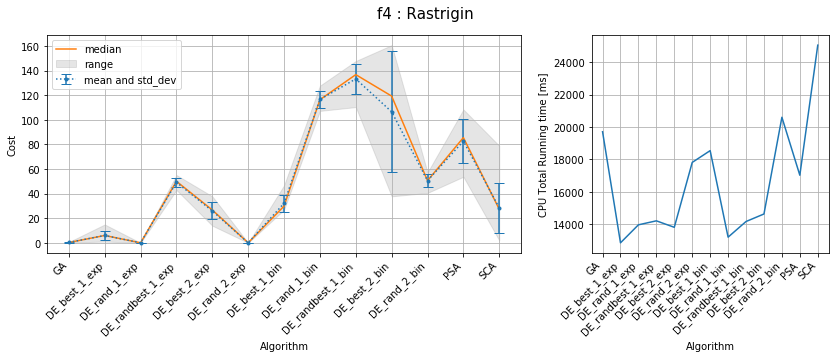

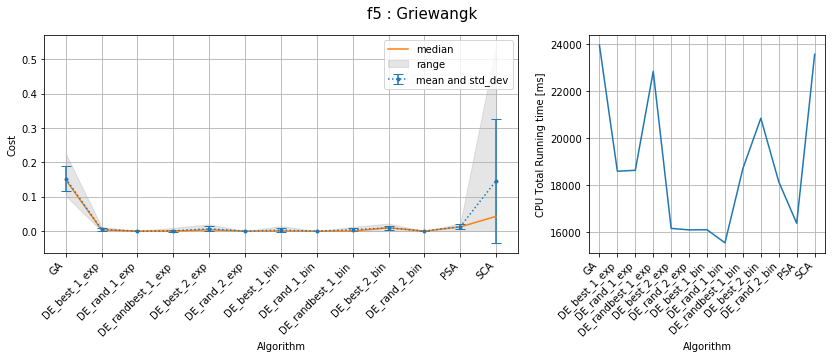

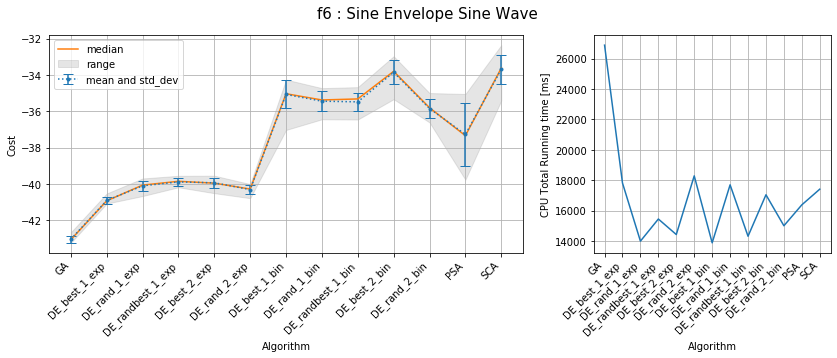

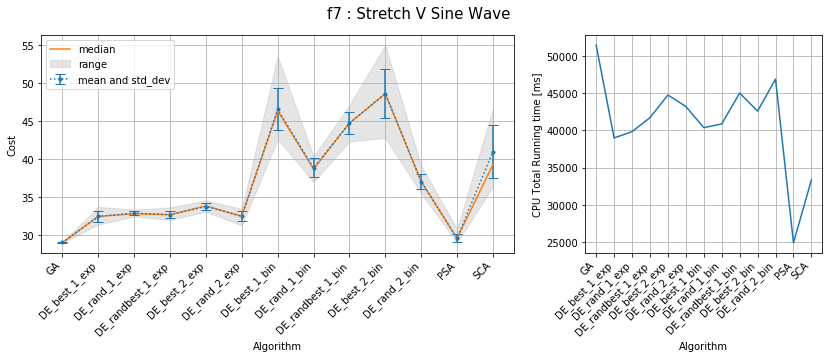

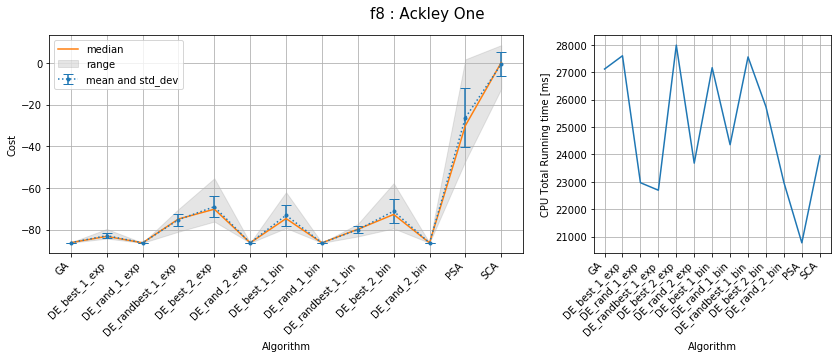

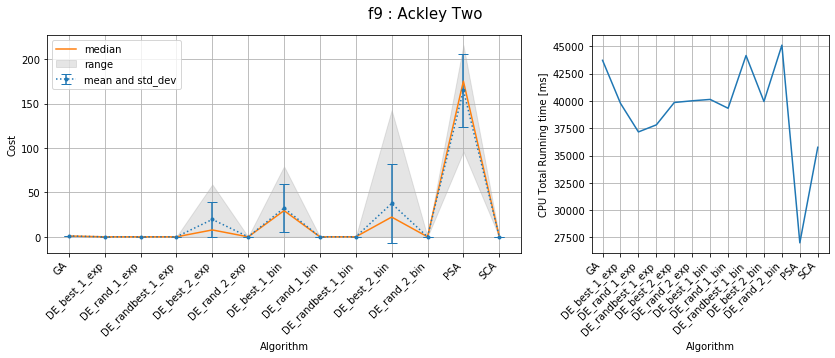

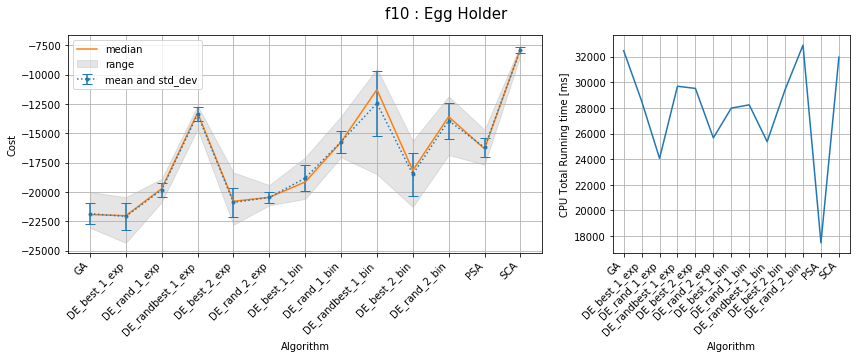

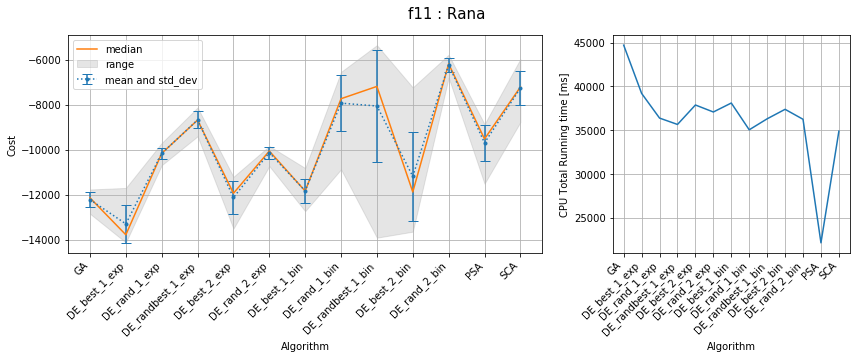

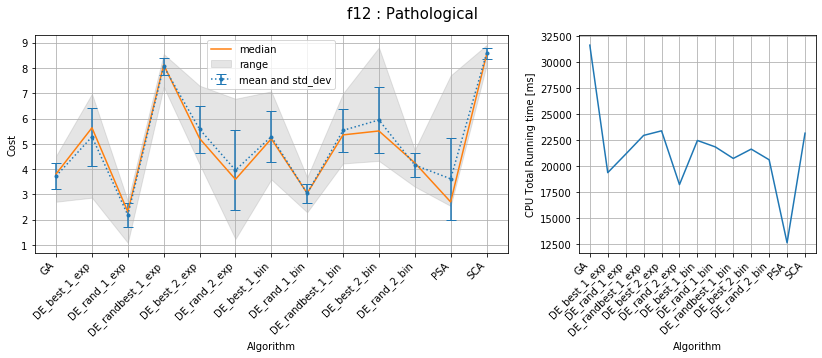

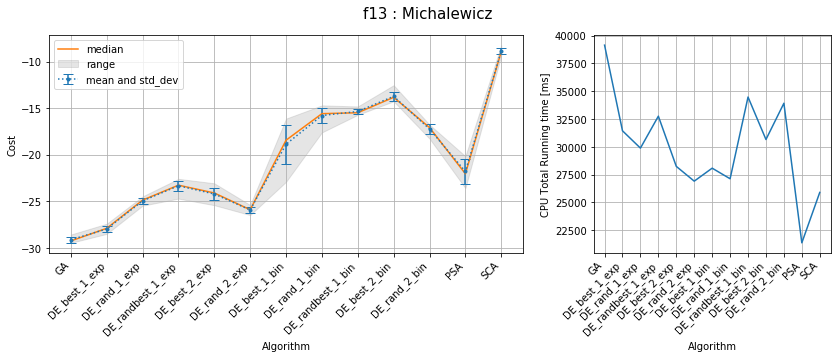

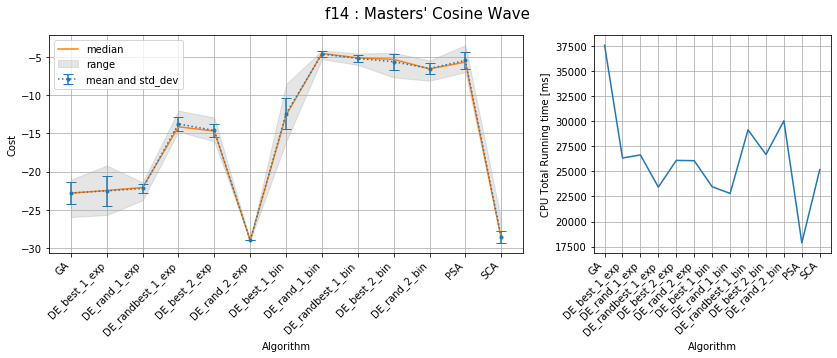

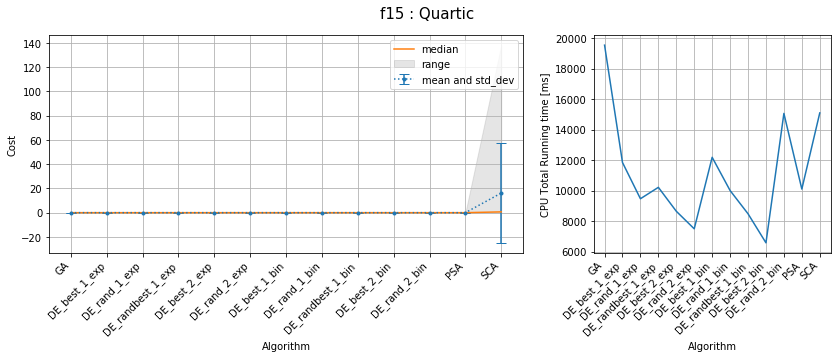

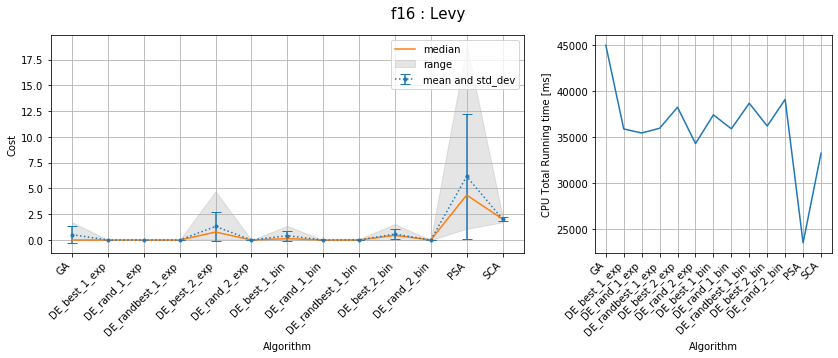

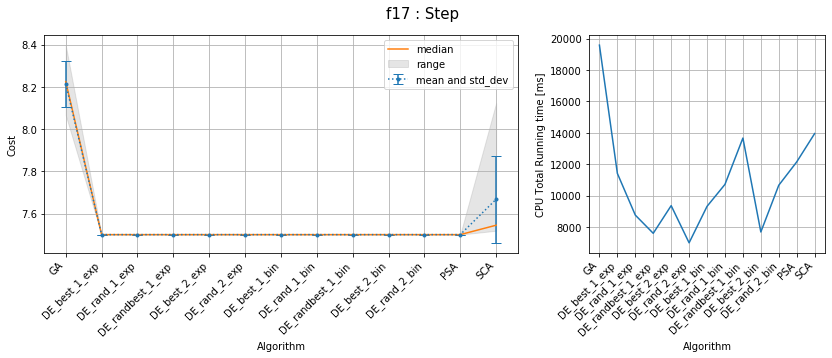

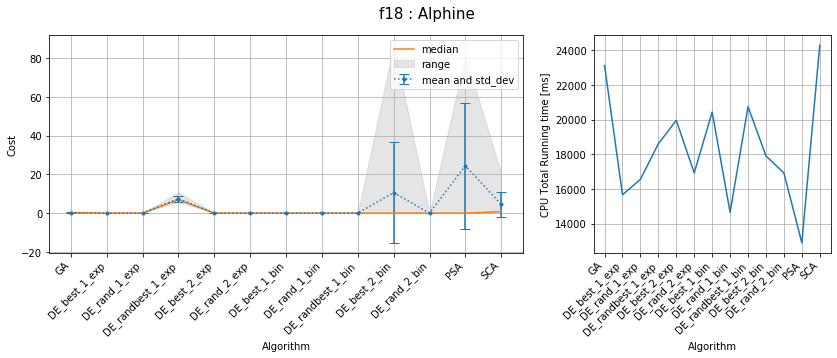

In [57]:
test.plot()

In [58]:
pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)
test.solution_df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,10,30,-512,512.000,247.124,153.399,592.658,237.206,22086,0.081,592.739
10,0,2,10,30,-100,100.000,0.023,0.007,0.021,0.023,13158,0.016,0.037
11,0,3,10,30,-100,100.000,113.822,47.783,152.145,97.767,11496,56.502,208.647
12,0,4,10,30,-30,30.000,0.319,0.146,0.439,0.269,19709,0.187,0.625
13,0,5,10,30,-500,500.000,0.153,0.037,0.123,0.149,23960,0.103,0.226
14,0,6,10,30,-30,30.000,-43.050,0.186,0.579,-43.074,26892,-43.247,-42.667
15,0,7,10,30,-30,30.000,29.059,0.038,0.118,29.053,51461,29.010,29.128
16,0,8,10,30,-32,32.000,-86.237,0.029,0.097,-86.237,27121,-86.266,-86.169
17,0,9,10,30,-32,32.000,0.925,0.168,0.633,0.933,43728,0.513,1.146
1,0,10,10,30,-500,500.000,-21857.000,871.604,3052.920,-21925.000,32462,-23056.300,-20003.400


In [59]:
df = test.solution_df.sort_values(by=['function_id','algorithm_id' ], inplace = False)
df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,10,30,-512,512.000,247.124,153.399,592.658,237.206,22086,0.081,592.739
72,1,1,10,30,-512,512.000,382.518,145.361,462.697,459.012,16226,114.754,577.451
90,2,1,10,30,-512,512.000,0.001,0.001,0.002,0.001,19004,0.000,0.002
108,3,1,10,30,-512,512.000,3609.470,222.611,861.189,3609.040,21072,3161.370,4022.560
126,4,1,10,30,-512,512.000,1162.170,297.878,1125.170,1095.690,16208,688.525,1813.700
144,5,1,10,30,-512,512.000,-0.002,0.000,0.001,-0.002,15655,-0.002,-0.001
162,6,1,10,30,-512,512.000,1933.600,204.884,676.156,1850.790,22122,1610.230,2286.390
180,7,1,10,30,-512,512.000,5246.210,158.108,476.000,5226.350,17880,4992.790,5468.790
198,8,1,10,30,-512,512.000,2039.600,647.134,2076.090,2136.160,15927,1151.270,3227.360
216,9,1,10,30,-512,512.000,1983.420,333.976,1122.800,2012.400,19435,1388.090,2510.900


# Read solution.csv, generate plot and latex report

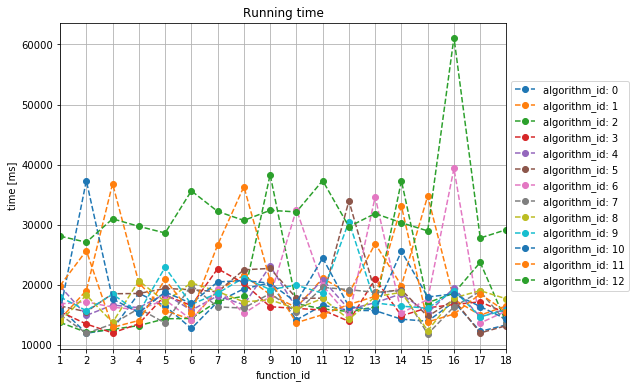

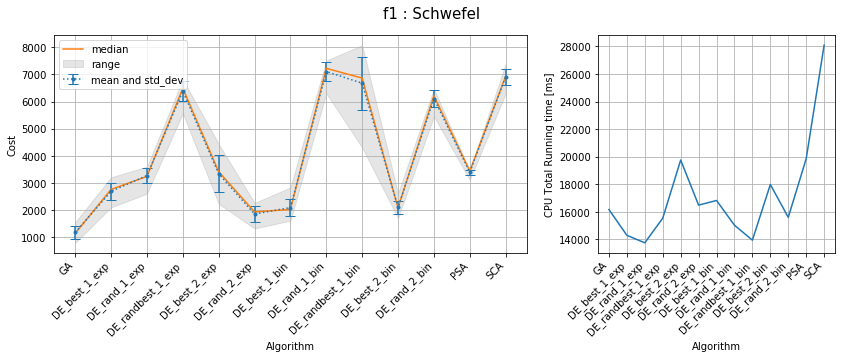

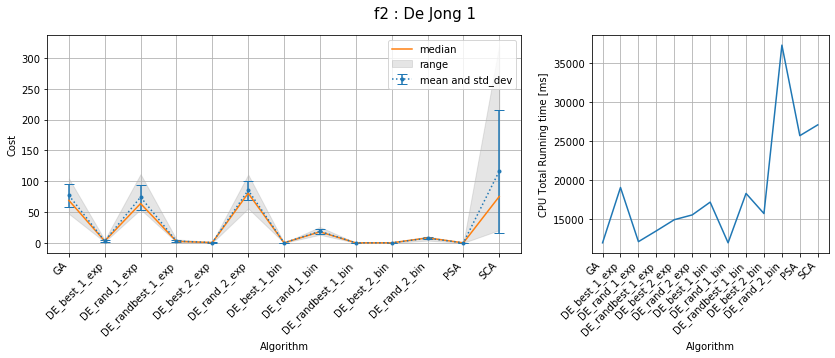

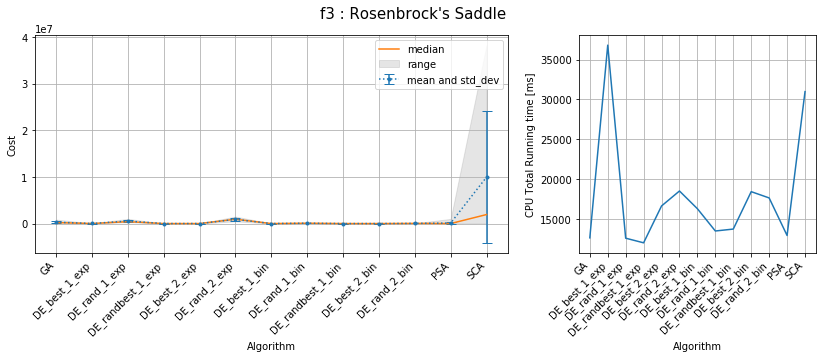

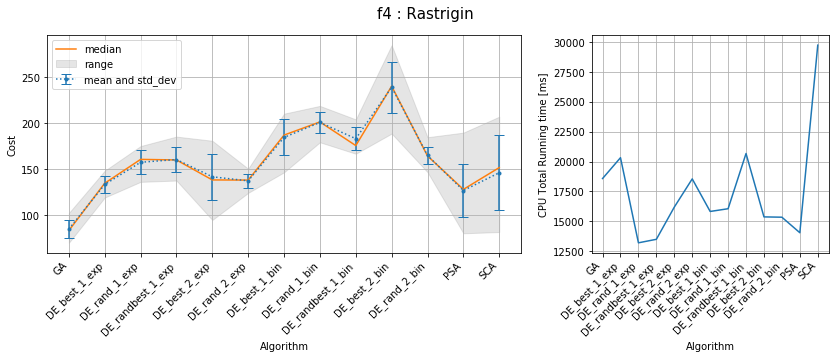

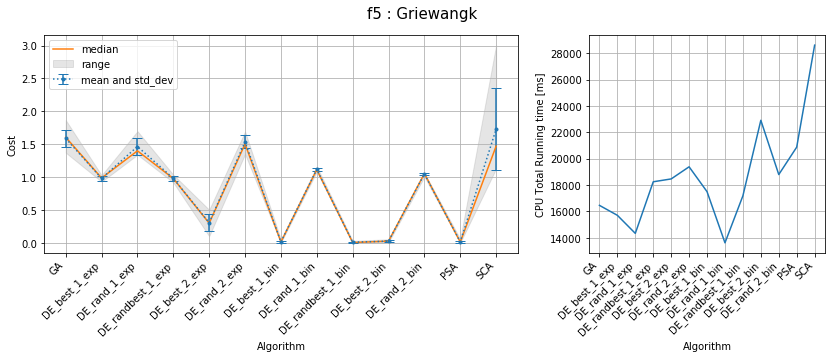

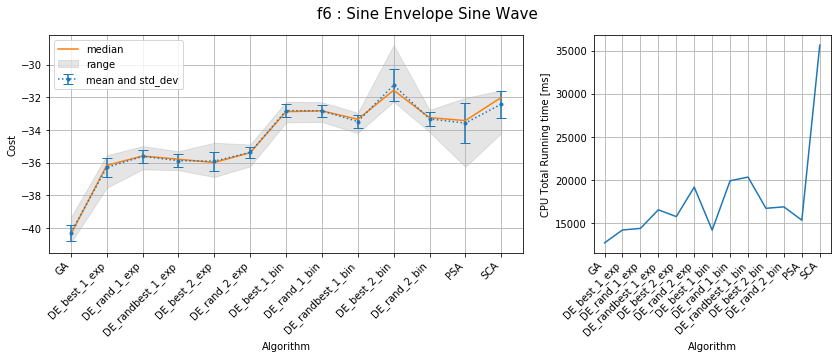

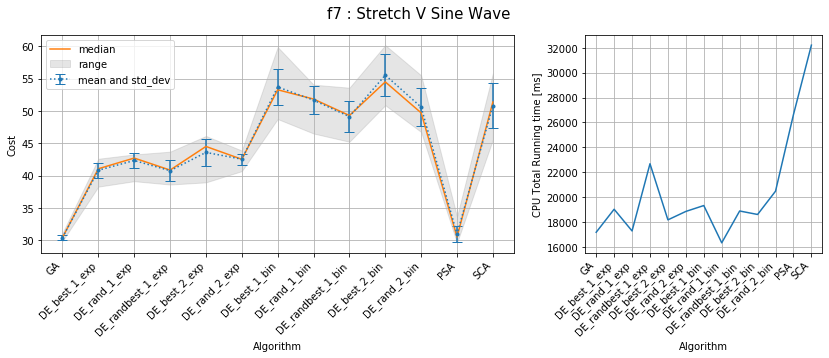

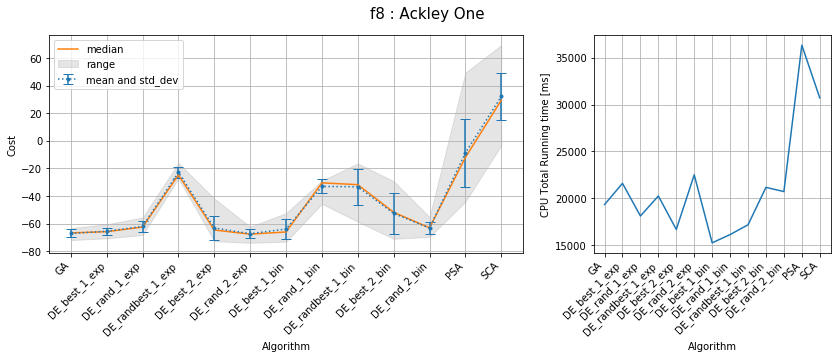

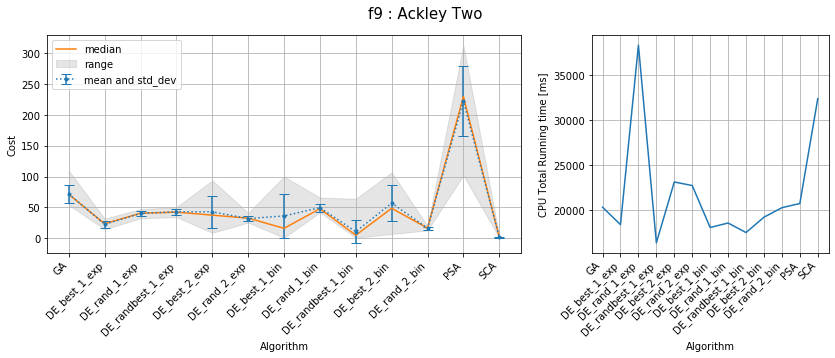

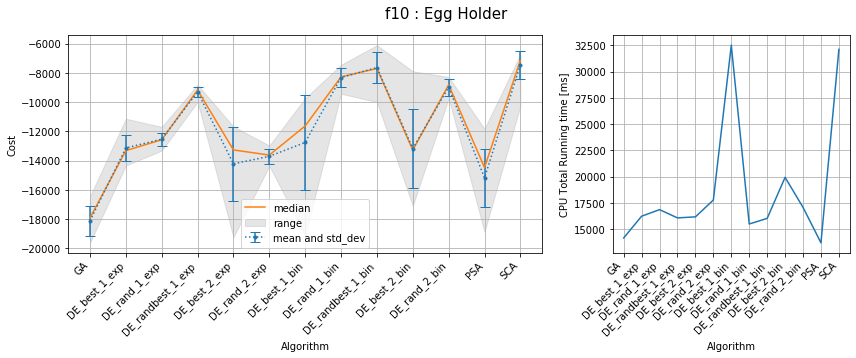

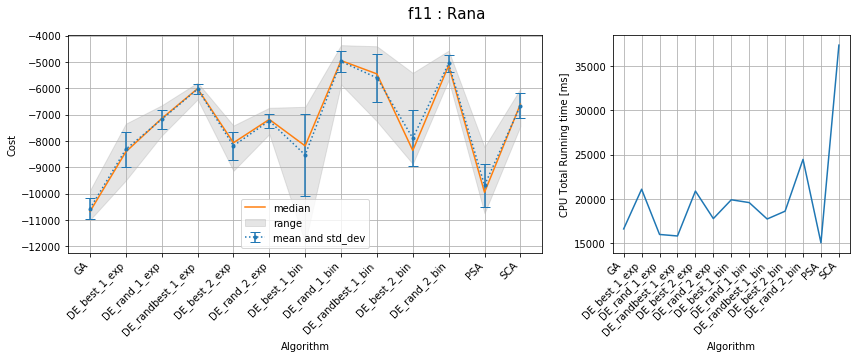

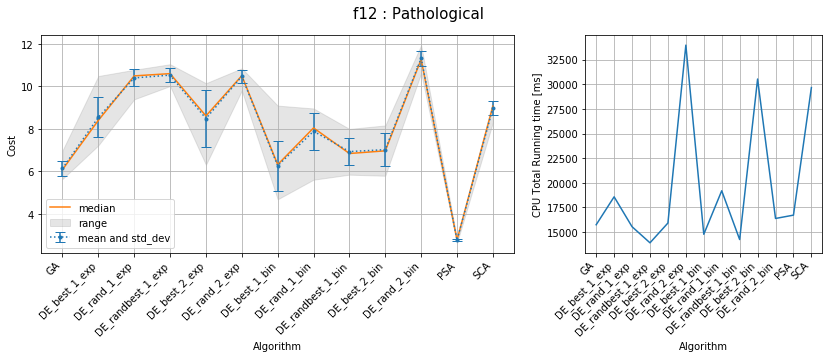

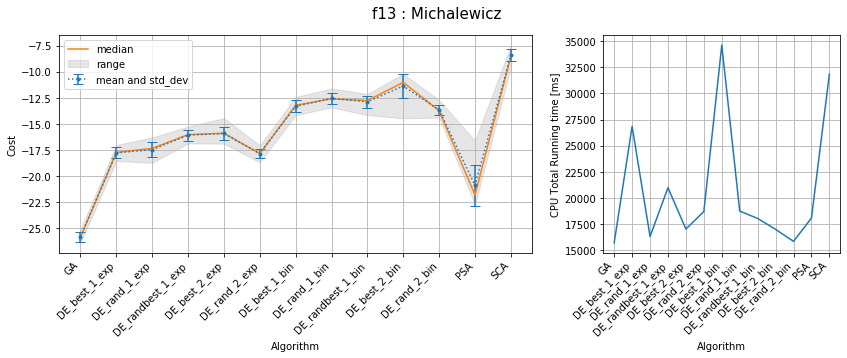

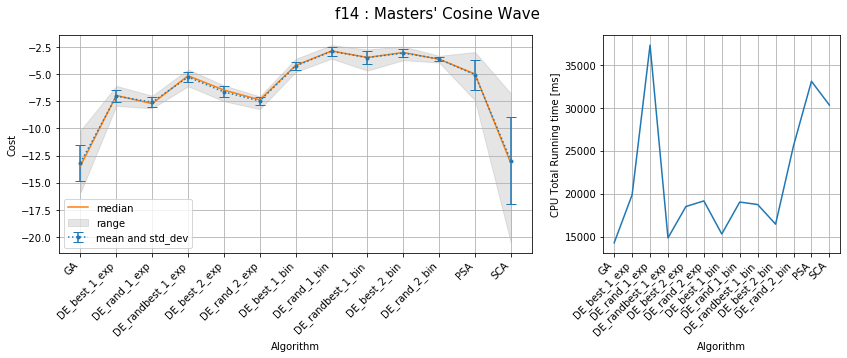

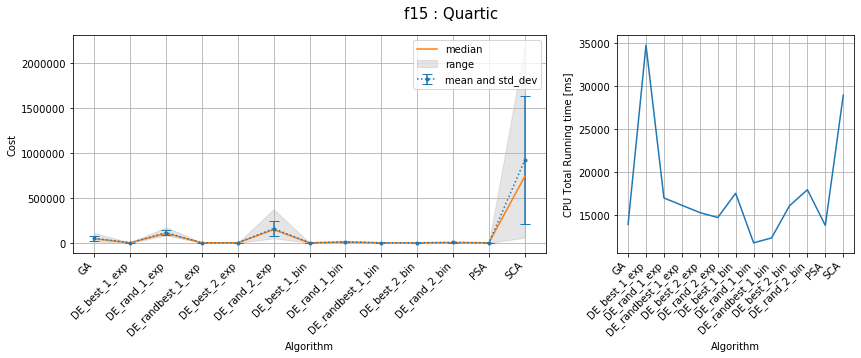

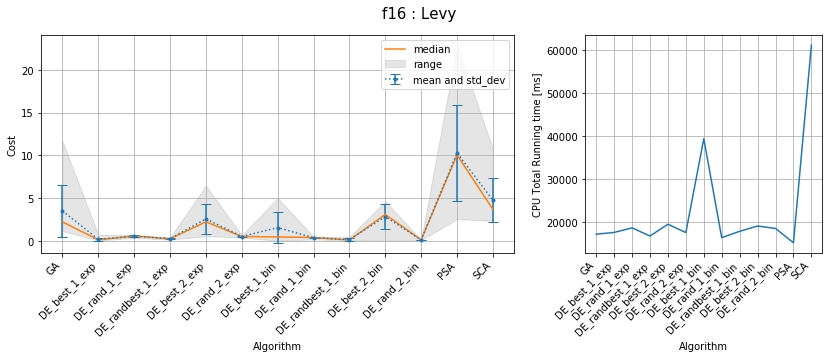

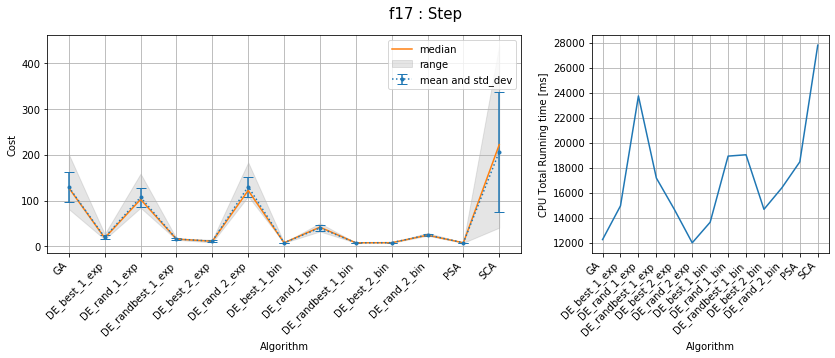

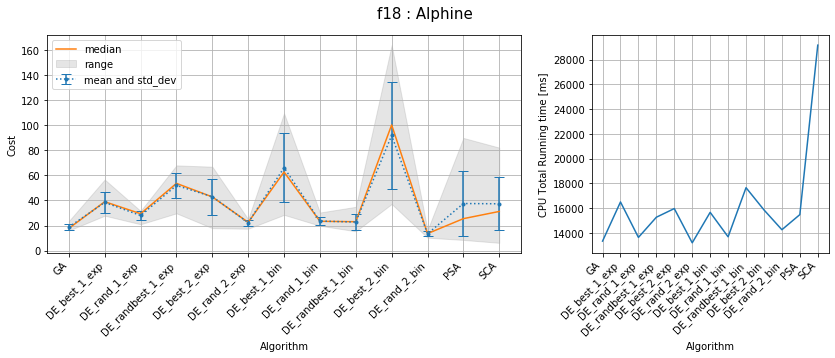

In [237]:
df=pd.read_csv("../out/optimization/"+'solutions.csv',index_col=False)
df.sort_values(by=['algorithm_id', 'function_id'], inplace = True)


#-----------plot running time
fig, ax = plt.subplots(figsize=(8,6))
for label, data in df.groupby('algorithm_id'):
    data.plot(kind='line',x='function_id',y='time_ms',ax=ax, style='o--', xticks=data['function_id'], label='algorithm_id: %d'%label)
plt.ylabel('time [ms]')    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.title('Running time')
#plt.savefig("running_time.png",bbox_inches='tight')


#---------plot statistics
for id, data in df.groupby('function_id'):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4),gridspec_kw={'width_ratios': [2, 1]})
    ax1.errorbar(data['algorithm_id'],data['mean'],yerr=data['std_dev'],fmt='o:', markersize=3, capsize=5, label='mean and std_dev')
    ax1.plot(data['algorithm_id'],data['median'],label='median')
    ax1.fill_between(data['algorithm_id'], data['range_min'], data['range_max'], color='gray', alpha=0.2, label='range')
    locs = [int(i) for i in test.opt_param_list_id]
    names = test.opt_param_list_name
    ax1.set_xticks(locs, minor=False)
    ax1.set_xticklabels(names, rotation=45, horizontalalignment='right')
    #ax1.xticks(locs,, rotation=45, horizontalalignment='right')
    fig.suptitle("f%d : %s"%(id, test.f_param_list_name[id-1]), fontsize=15)
    #ax1.set_title("f%d : %s"%(id, test.f_param_list_name[id-1]))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.legend()
    ax1.set_xlabel('Algorithm')
    ax1.set_ylabel('Cost')
    ax1.grid()
    
    ax2.plot(data['algorithm_id'],data['time_ms'])
    ax2.set_ylabel('CPU Total Running time [ms]')
    ax2.set_xlabel('Algorithm')
    ax2.set_xticks(locs, minor=False)
    ax2.set_xticklabels(names, rotation=45, horizontalalignment='right')
    ax2.grid()
    #plt.savefig("f"+str(id)+".png",bbox_inches='tight')


In [60]:
pd.options.display.max_rows
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', None)
df

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,10,30,-512,512.000,247.124,153.399,592.658,237.206,22086,0.081,592.739
72,1,1,10,30,-512,512.000,382.518,145.361,462.697,459.012,16226,114.754,577.451
90,2,1,10,30,-512,512.000,0.001,0.001,0.002,0.001,19004,0.000,0.002
108,3,1,10,30,-512,512.000,3609.470,222.611,861.189,3609.040,21072,3161.370,4022.560
126,4,1,10,30,-512,512.000,1162.170,297.878,1125.170,1095.690,16208,688.525,1813.700
144,5,1,10,30,-512,512.000,-0.002,0.000,0.001,-0.002,15655,-0.002,-0.001
162,6,1,10,30,-512,512.000,1933.600,204.884,676.156,1850.790,22122,1610.230,2286.390
180,7,1,10,30,-512,512.000,5246.210,158.108,476.000,5226.350,17880,4992.790,5468.790
198,8,1,10,30,-512,512.000,2039.600,647.134,2076.090,2136.160,15927,1151.270,3227.360
216,9,1,10,30,-512,512.000,1983.420,333.976,1122.800,2012.400,19435,1388.090,2510.900


## support codes for latex report generation

In [61]:
# https://stats.stackexchange.com/questions/124096/two-samples-z-test-in-python
def twoSampZ(X1, X2, mudiff, sd1, sd2, n1, n2):
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
    z = ((X1 - X2) - mudiff)/pooledSE
    pval = 2*(1 - norm.cdf(abs(z)))
    return round(z, 3), round(pval, 4)

z, p = twoSampZ(1330, 1350, 0, 388.5, 190.64, 50, 50)

In [62]:
df_s = df.sort_values(by=['function_id','algorithm_id' ], inplace = False)
df_s
n_sample = df_s["n_runs"].iloc[0]

# print the table and export to latex

In [63]:
def print_latex_function(function_id):
    df_fx = df_s[df_s["function_id"]==function_id] # dataframe of function_id
    
    # get name of the algorithms
    alg_id = [str(i) for i in df_fx["algorithm_id"].values.tolist()] # convert algorithm id to string
    alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
    alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
    # insert algorithms name to the dataframe
    df_fx = df_fx[["mean","std_dev","median","range_min","range_max","time_ms"]]
    df_fx.insert(0,"algorithm",alg_name)
    #display(df_fx)
    
    # get name of the functions
    f_index = test.f_param_list_function_id.index(str(function_id))
    f_name = test.f_param_list_name[f_index]
    
        
    #print subsection 
    print("\\subsection{Function %d: %s}"%(function_id, f_name))
    
    
    #print function
    print("""
    \\begin{figure}[H]
    \\centering
    
    \\includegraphics[width=1\\linewidth]{{"figures/figures - linux 1 cpu/f%d"}.png}
    
    \\caption{Cost and CPU total running time of Function %d: %s} 
    \\label{fig:f%d}
    \\end{figure}
    """%(function_id, function_id, f_name, function_id))


    
    # print latex table
    print("""\\begin{table}[H]
    \\centering
    \\footnotesize""")
    print(df_fx.to_latex(index=False))
    print("""\\caption{Function %d: Statistical Analysis of the Cost} 
    \\end{table}"""%function_id)
    
    
    # Hypothesis testing 
    #find the min beside GA
    #df_ga = df_fx[df_fx["algorithm"]=="GA"]
    #df_fx = df_fx[df_fx["algorithm"]!="GA"]
    min_index = df_fx[['mean']].idxmin()
    df_min = df_fx.loc[min_index] # minimun 
    x1=df_min["mean"].values[0]
    sd1=df_min["std_dev"].values[0]
    
   
    min_latex = df_min["algorithm"].values[0].replace("_","\_")
    print("Best Algorithm: \\\\")
    print("\\textbf{%s}, Cost (mean): %f\\\\"%(min_latex, x1))
        
    # save the good algorithms after the hypothesis testing
    good_alg = []
    # compare everyone with the best
    already_printed=False
    for index, row in df_fx.iterrows():
        if index != min_index.values[0]: #exclude compare with itself
  
            #get name
            current_latex = row["algorithm"].replace("_","\_")
            
            #preparing data for z-test (two sample)
            x2=row["mean"]
            sd2=row["std_dev"]

            z,p = twoSampZ(x1,x2,0,sd1,sd2,n_sample,n_sample)

            

            if(p>0.05):
                if not already_printed:
                    print("\\noindent")
                    print("\\textbf{Two-Sample Z-Test Hypothesis Testing: }")
                    print("confidence interval = 95\%\\\\")
                    already_printed = True
          
                print("\\textbf{%s}, Cost (mean): %f"%(current_latex, x2))
                print(" P value: %f   "%p)
                print("\\textbf{the cost of %s is equal to the cost of %s}.\\\\"%(current_latex, min_latex))
                good_alg.append(row["algorithm"])
    
    return good_alg

print_latex_function(8)

\subsection{Function 8: Ackley One}

    \begin{figure}[H]
    \centering
    
    \includegraphics[width=1\linewidth]{{"figures/figures - linux 1 cpu/f8"}.png}
    
    \caption{Cost and CPU total running time of Function 8: Ackley One} 
    \label{fig:f8}
    \end{figure}
    
\begin{table}[H]
    \centering
    \footnotesize
\begin{tabular}{lrrrrrr}
\toprule
         algorithm &    mean &  std\_dev &  median &  range\_min &  range\_max &  time\_ms \\
\midrule
                GA & -86.237 &    0.029 & -86.237 &    -86.266 &    -86.169 &    27121 \\
     DE\_best\_1\_exp & -82.897 &    1.334 & -83.235 &    -84.287 &    -79.689 &    27606 \\
     DE\_rand\_1\_exp & -86.333 &    0.000 & -86.333 &    -86.333 &    -86.333 &    22968 \\
 DE\_randbest\_1\_exp & -75.211 &    2.825 & -74.903 &    -80.977 &    -70.186 &    22693 \\
     DE\_best\_2\_exp & -68.986 &    5.119 & -70.178 &    -76.134 &    -55.360 &    27994 \\
     DE\_rand\_2\_exp & -86.333 &    0.000 & -86.333 &    -86.333 &    

['DE_rand_2_exp', 'DE_rand_1_bin', 'DE_rand_2_bin']

## Print latex

In [64]:
function_list = df_s["function_id"].unique()
good_algs = []
for i in function_list:
    good_algs.append(print_latex_function(i))

\subsection{Function 1: Schwefel}

    \begin{figure}[H]
    \centering
    
    \includegraphics[width=1\linewidth]{{"figures/figures - linux 1 cpu/f1"}.png}
    
    \caption{Cost and CPU total running time of Function 1: Schwefel} 
    \label{fig:f1}
    \end{figure}
    
\begin{table}[H]
    \centering
    \footnotesize
\begin{tabular}{lrrrrrr}
\toprule
         algorithm &     mean &  std\_dev &   median &  range\_min &  range\_max &  time\_ms \\
\midrule
                GA &  247.124 &  153.399 &  237.206 &      0.081 &    592.739 &    22086 \\
     DE\_best\_1\_exp &  382.518 &  145.361 &  459.012 &    114.754 &    577.451 &    16226 \\
     DE\_rand\_1\_exp &    0.001 &    0.001 &    0.001 &      0.000 &      0.002 &    19004 \\
 DE\_randbest\_1\_exp & 3609.470 &  222.611 & 3609.040 &   3161.370 &   4022.560 &    21072 \\
     DE\_best\_2\_exp & 1162.170 &  297.878 & 1095.690 &    688.525 &   1813.700 &    16208 \\
     DE\_rand\_2\_exp &   -0.002 &    0.000 &   -0.002 &     -0

c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


## get algorithms with similar result comparing to the best

In [65]:
good_algs_s = [", ".join(i) for i in good_algs]
good_algs_s

['',
 'DE_best_2_exp',
 'PSA',
 'DE_rand_1_exp',
 'DE_randbest_1_exp, DE_best_1_bin',
 '',
 '',
 'DE_rand_2_exp, DE_rand_1_bin, DE_rand_2_bin',
 '',
 'GA',
 '',
 '',
 '',
 'SCA',
 'DE_best_1_exp, DE_randbest_1_exp, SCA',
 'DE_randbest_1_bin',
 'DE_rand_1_exp, DE_randbest_1_exp, DE_best_2_exp, DE_rand_2_exp, DE_best_1_bin, DE_rand_1_bin, DE_randbest_1_bin, DE_best_2_bin, DE_rand_2_bin, PSA',
 'DE_best_2_exp, DE_best_1_bin, DE_randbest_1_bin, DE_best_2_bin']

In [66]:
df_similar=pd.DataFrame(list(zip(function_list,good_algs_s)), columns = ['function_id','similar_result'])

# print summary table

In [67]:
df_summary = df.sort_values(by=['algorithm_id','function_id'], inplace = False)
df_summary

,algorithm_id,function_id,n_runs,dimensions,range_low,range_high,mean,std_dev,range,median,time_ms,range_min,range_max
0,0,1,10,30,-512,512.000,247.124,153.399,592.658,237.206,22086,0.081,592.739
10,0,2,10,30,-100,100.000,0.023,0.007,0.021,0.023,13158,0.016,0.037
11,0,3,10,30,-100,100.000,113.822,47.783,152.145,97.767,11496,56.502,208.647
12,0,4,10,30,-30,30.000,0.319,0.146,0.439,0.269,19709,0.187,0.625
13,0,5,10,30,-500,500.000,0.153,0.037,0.123,0.149,23960,0.103,0.226
14,0,6,10,30,-30,30.000,-43.050,0.186,0.579,-43.074,26892,-43.247,-42.667
15,0,7,10,30,-30,30.000,29.059,0.038,0.118,29.053,51461,29.010,29.128
16,0,8,10,30,-32,32.000,-86.237,0.029,0.097,-86.237,27121,-86.266,-86.169
17,0,9,10,30,-32,32.000,0.925,0.168,0.633,0.933,43728,0.513,1.146
1,0,10,10,30,-500,500.000,-21857.000,871.604,3052.920,-21925.000,32462,-23056.300,-20003.400


In [48]:
df_result = df_summary.groupby(by=["function_id"], as_index=False).first()
df_result = df_result[["function_id"]] # get the dataframe of only function id

alg_id = df_summary["algorithm_id"].unique()
alg_id = [str(i) for i in alg_id]    # convert algorithm id to string
alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
for label, data in df_summary.groupby('algorithm_id'):
    temp = data[["function_id","mean"]]
    
    new_name = alg_name[int(label)]
    temp.rename(columns={'mean': new_name}, inplace=True)
    #display(temp)
    
    df_result=df_result.merge(temp, on=["function_id"], how='left') 
    
display(df_result)
print(df_result.to_latex(index=False))

c:\users\chao_\miniconda3\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,function_id,GA,DE_best_1_exp,DE_rand_1_exp,DE_randbest_1_exp,DE_best_2_exp,DE_rand_2_exp,DE_best_1_bin,DE_rand_1_bin,DE_randbest_1_bin,DE_best_2_bin,DE_rand_2_bin,PSA,SCA
0,1,118.680,581.138,0.001,3110.190,1273.340,-0.002,1486.790,4839.420,1969.320,1277.030,3974.410,3327.850,6319.560
1,2,0.017,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.005
2,3,81.037,10.079,24.518,28.291,24.646,13.471,14.948,25.332,30.475,3.708,91.688,9.403,2099.660
3,4,0.360,2.985,0.000,49.231,15.919,0.000,53.728,115.403,141.441,94.112,44.992,87.556,47.649
4,5,0.188,0.000,0.000,0.000,0.000,0.000,0.010,0.000,0.000,0.020,0.000,0.007,0.071
5,6,-43.086,-40.692,-40.168,-39.524,-39.736,-40.131,-35.987,-34.907,-34.980,-34.612,-35.869,-37.346,-34.336
6,7,29.073,32.789,33.216,32.751,35.060,33.026,48.723,39.617,42.197,53.859,37.044,31.452,45.343
7,8,-86.196,-81.274,-86.333,-72.740,-74.694,-86.333,-78.396,-86.332,-78.376,-71.086,-86.333,-32.797,-0.919
8,9,0.868,0.000,0.000,0.000,30.103,0.000,-0.000,0.000,2.580,37.947,0.000,259.240,0.003
9,10,-21705.400,-21928.200,-18282.900,-13932.800,-18395.900,-20325.900,-20068.800,-16306.200,-9303.230,-17684.400,-14484.500,-16456.000,-7690.540


\begin{tabular}{rrrrrrrrrrrrrr}
\toprule
 function\_id &         GA &  DE\_best\_1\_exp &  DE\_rand\_1\_exp &  DE\_randbest\_1\_exp &  DE\_best\_2\_exp &  DE\_rand\_2\_exp &  DE\_best\_1\_bin &  DE\_rand\_1\_bin &  DE\_randbest\_1\_bin &  DE\_best\_2\_bin &  DE\_rand\_2\_bin &        PSA &       SCA \\
\midrule
           1 &    118.680 &        581.138 &          0.001 &           3110.190 &       1273.340 &         -0.002 &       1486.790 &       4839.420 &           1969.320 &       1277.030 &       3974.410 &   3327.850 &  6319.560 \\
           2 &      0.017 &          0.000 &          0.000 &              0.000 &          0.000 &          0.000 &          0.000 &          0.000 &              0.000 &          0.000 &          0.000 &      0.000 &     0.005 \\
           3 &     81.037 &         10.079 &         24.518 &             28.291 &         24.646 &         13.471 &         14.948 &         25.332 &             30.475 &          3.708 &         91.688 &      9.403 &  209

In [49]:
df_result

,function_id,GA,DE_best_1_exp,DE_rand_1_exp,DE_randbest_1_exp,DE_best_2_exp,DE_rand_2_exp,DE_best_1_bin,DE_rand_1_bin,DE_randbest_1_bin,DE_best_2_bin,DE_rand_2_bin,PSA,SCA
0,1,118.680,581.138,0.001,3110.190,1273.340,-0.002,1486.790,4839.420,1969.320,1277.030,3974.410,3327.850,6319.560
1,2,0.017,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.005
2,3,81.037,10.079,24.518,28.291,24.646,13.471,14.948,25.332,30.475,3.708,91.688,9.403,2099.660
3,4,0.360,2.985,0.000,49.231,15.919,0.000,53.728,115.403,141.441,94.112,44.992,87.556,47.649
4,5,0.188,0.000,0.000,0.000,0.000,0.000,0.010,0.000,0.000,0.020,0.000,0.007,0.071
5,6,-43.086,-40.692,-40.168,-39.524,-39.736,-40.131,-35.987,-34.907,-34.980,-34.612,-35.869,-37.346,-34.336
6,7,29.073,32.789,33.216,32.751,35.060,33.026,48.723,39.617,42.197,53.859,37.044,31.452,45.343
7,8,-86.196,-81.274,-86.333,-72.740,-74.694,-86.333,-78.396,-86.332,-78.376,-71.086,-86.333,-32.797,-0.919
8,9,0.868,0.000,0.000,0.000,30.103,0.000,-0.000,0.000,2.580,37.947,0.000,259.240,0.003
9,10,-21705.400,-21928.200,-18282.900,-13932.800,-18395.900,-20325.900,-20068.800,-16306.200,-9303.230,-17684.400,-14484.500,-16456.000,-7690.540


## get best cost without time

In [68]:
df_best = df_result[["function_id"]]
df_best["best_algorithm"] = df_result.drop(columns=["function_id"]).idxmin(axis=1)
df_best["best_cost"] = df_result.drop(columns=["function_id"]).min(axis=1)
df_best

c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,function_id,best_algorithm,best_cost
0,1,DE_rand_2_exp,-0.002
1,2,PSA,0.000
2,3,DE_best_2_bin,3.708
3,4,DE_rand_2_exp,0.000
4,5,DE_rand_2_bin,0.000
5,6,GA,-43.086
6,7,GA,29.073
7,8,DE_rand_1_exp,-86.333
8,9,DE_best_1_bin,-0.000
9,10,DE_best_1_exp,-21928.200


In [69]:
df_best.merge(df_similar, on=["function_id"], how='left') 

,function_id,best_algorithm,best_cost,similar_result
0,1,DE_rand_2_exp,-0.002,
1,2,PSA,0.000,DE_best_2_exp
2,3,DE_best_2_bin,3.708,PSA
3,4,DE_rand_2_exp,0.000,DE_rand_1_exp
4,5,DE_rand_2_bin,0.000,"DE_randbest_1_exp, DE_best_1_bin"
5,6,GA,-43.086,
6,7,GA,29.073,
7,8,DE_rand_1_exp,-86.333,"DE_rand_2_exp, DE_rand_1_bin, DE_rand_2_bin"
8,9,DE_best_1_bin,-0.000,
9,10,DE_best_1_exp,-21928.200,GA


## get best cost with time

In [70]:
df_result = df_summary.groupby(by=["function_id"], as_index=False).first()
df_result = df_result[["function_id"]] # get the dataframe of only function id

alg_id = df_summary["algorithm_id"].unique()
alg_id = [str(i) for i in alg_id]    # convert algorithm id to string
alg_index = [test.opt_param_list_id.index(i) for i in alg_id] # get the index of alg id
alg_name = [test.opt_param_list_name[i] for i in alg_index] # get the name
    
for label, data in df_summary.groupby('algorithm_id'):
    temp = data[["function_id","mean"]]
    
    new_name = int(label)
    temp.rename(columns={'mean': new_name}, inplace=True)
    #display(temp)
    
    df_result=df_result.merge(temp, on=["function_id"], how='left') 
    
#display(df_result)
#print(df_result.to_latex(index=False))

In [71]:
df_best = df_result[["function_id"]]
df_best["algorithm_id"] = df_result.drop(columns=["function_id"]).idxmin(axis=1)
df_best["best_cost"] = df_result.drop(columns=["function_id"]).min(axis=1)
temp = df[["algorithm_id", "function_id", "time_ms"]]
df_best = df_best.merge(temp, on=["function_id","algorithm_id"], how='left') 
df_best

c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\chao_\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,function_id,algorithm_id,best_cost,time_ms
0,1,0,1330.170,2158.370
1,2,8,0.002,1249.120
2,3,6,520.354,1260.940
3,4,0,-67715.300,2311.080
4,5,8,0.011,2978.360
5,6,0,-40.070,2505.260
6,7,0,30.665,4661.080
7,8,0,-68.615,3126.870
8,9,8,8.953,4897.940
9,10,0,-18226.300,3839.400
